In [1]:
import numpy as np
import random

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd


# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()


,X1,X2,color
0,0.143523,-0.182869,c2
1,-0.725673,-0.131406,c2
2,-0.246789,-0.808881,c1
3,-0.035371,-0.826899,c1
4,-0.455321,-0.780738,c1


In [4]:
# Data shapes
X = df[['X1', 'X2']].values
y = df['color'].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))


X:  (1500, 2)
y:  (1500,)


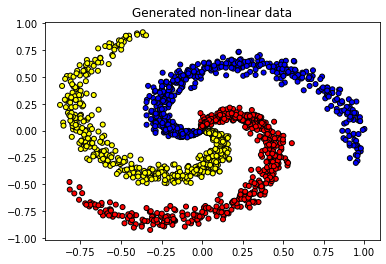

In [5]:
# Visualize data
plt.title("Generated non-linear data")
colors = {'c1': 'red', 'c2': 'yellow', 'c3': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors='k', s=25)
plt.show()


In [6]:
import collections
from sklearn.model_selection import train_test_split

In [7]:
TRAIN_SIZE = 0.7
TEST_SIZE= .15
VAL_SIZE = .15

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test



In [8]:
_# Create data splits
X_train, X_val, X_test  ,  y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)

print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [0.32833824 0.06478865] → c1


In [9]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

labelEncoder.fit(y_train)
classes = list(labelEncoder.classes_)
print(f'classes :', classes)

classes : ['c1', 'c2', 'c3']


In [10]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = labelEncoder.transform(y_train)
y_val = labelEncoder.transform(y_val)
y_test = labelEncoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")


y_train[0]: c1
y_train[0]: 0


In [11]:
#calculate Class weights

counts = np.bincount(y_train)
for i , count in enumerate(counts):
  print(i, count)

class_weights = {i: 1.0/count for i , count in enumerate(counts)}
print(class_weights)

0 350
1 350
2 350
{0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


In [12]:
#standardize data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")



X_test[0]: mean: 0.0, std: 1.1
X_test[1]: mean: 0.1, std: 1.0


In [13]:
import torch

torch.manual_seed(42)

from torch import nn
from torch.functional import F

INPUT_DIM = X_train.shape[1]
CLASSES = len(classes)
HIDDEN_DIM = 100

class t_LR(nn.Module):
  def __init__(self , input_dim , hidden_dim , num_classes):
    super(t_LR,self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim , num_classes)

  def forward(self, x_in , apply_softmax = False):
    z = self.fc1(x_in)
    y_pred = self.fc2(z)

    if apply_softmax:
      y_pred =F.softmax(y_pred, dim=1)

    return y_pred

In [14]:
#initialize model

model = t_LR(input_dim=INPUT_DIM , hidden_dim = HIDDEN_DIM , num_classes=CLASSES)
print(model.named_parameters)

<bound method Module.named_parameters of t_LR(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [15]:
from torch.optim import Adam

LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIIZE = 32

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight = class_weights_tensor)

In [16]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy


In [17]:
# Convert data numpy to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [18]:
#Training

for epoch in range(NUM_EPOCHS):

  y_pred = model(X_train)

  loss = loss_fn(y_pred,y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  if epoch%1==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 1.07, accuracy: 45.0
Epoch: 1 | loss: 0.86, accuracy: 55.4
Epoch: 2 | loss: 0.77, accuracy: 53.0
Epoch: 3 | loss: 0.74, accuracy: 52.8
Epoch: 4 | loss: 0.73, accuracy: 53.0
Epoch: 5 | loss: 0.74, accuracy: 53.6
Epoch: 6 | loss: 0.75, accuracy: 53.5
Epoch: 7 | loss: 0.76, accuracy: 53.8
Epoch: 8 | loss: 0.76, accuracy: 55.0
Epoch: 9 | loss: 0.77, accuracy: 55.8


In [19]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance
# Predictions
y_prob = model(X_test, apply_softmax=True)
print (f"sample probability: {y_prob[0]}")
y_pred = y_prob.max(dim=1)[1]
print (f"sample class: {y_pred[0]}")


sample probability: tensor([0.2554, 0.5151, 0.2294], grad_fn=<SelectBackward>)
sample class: 1


In [20]:
# Performance report
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.5239924394853972,
    "recall": 0.5244444444444445,
    "f1": 0.524032684450853,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 0.5070422535211268,
      "recall": 0.48,
      "f1": 0.4931506849315068,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.5194805194805194,
      "recall": 0.5333333333333333,
      "f1": 0.5263157894736841,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.5454545454545454,
      "recall": 0.56,
      "f1": 0.5526315789473685,
      "num_samples": 75.0
    }
  }
}


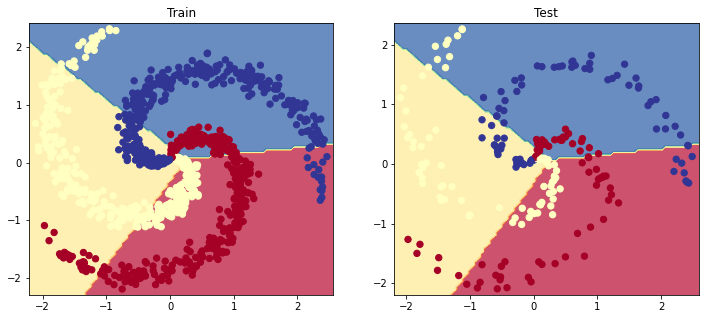

In [21]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


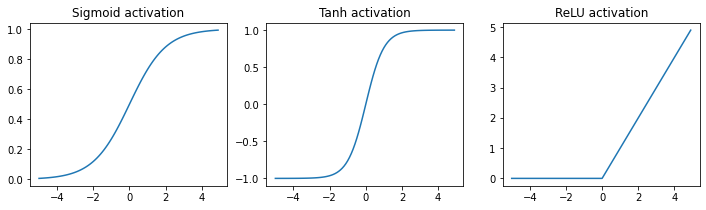

In [22]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()


In [34]:
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1= np.zeros((1,HIDDEN_DIM))
print (' input shape :',X_train.shape, '\n', 'weights shape :', W1.shape , '\n', 'bias shape :', b1.shape)

 input shape : torch.Size([1050, 2]) 
 weights shape : (2, 100) 
 bias shape : (1, 100)


In [35]:
# z1 = [NX2] · [2X100] + [1X100] = [NX100]

z1 = np.dot(X_train , W1) + b1
print ('z1 :', z1.shape)

z1 : (1050, 100)


In [37]:
#apply non linear activation functions

a1 = np.maximum(0,z1) # ReLU
print(f"A_1 : {a1.shape}")

A_1 : (1050, 100)


In [40]:
W2 = 0.01* np.random.randn(HIDDEN_DIM, CLASSES)
print(f" W2 shape {W2.shape}")
b2 = np.zeros((1,CLASSES))
print(f" b2 shape {b2.shape}")


 W2 shape (100, 3)
 b2 shape (1, 3)


In [42]:
logits = np.dot(a1 , W2) + b2
print ( f" logits shape {logits.shape} '\n' sample : {logits[0]}")

 logits shape (1050, 3) '
' sample : [ 1.04283807e-04 -3.68226636e-04  8.93667308e-05]


In [43]:
#apply softmax to Normalize the outputs

exp_logits = np.exp(logits)
y_hat = exp_logits/ np.sum(exp_logits,axis=1,keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (1050, 3)
sample: [0.33338749 0.33323    0.33338252]


In [44]:
#compute loss

# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")


loss: 1.10


In [45]:
#calculate gradients

# dJ/dW2
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW2 = np.dot(a1.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)


In [46]:
# dJ/dW1
dhidden = np.dot(dscores, W2.T)
dhidden[a1 <= 0] = 0 # ReLu backprop
dW1 = np.dot(X_train.T, dhidden)
db1 = np.sum(dhidden, axis=0, keepdims=True)


In [47]:
# Update weights
W1 += -LEARNING_RATE * dW1
b1 += -LEARNING_RATE * db1
W2 += -LEARNING_RATE * dW2
b2 += -LEARNING_RATE * db2


In [48]:
# Convert tensors to NumPy arrays
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()


In [50]:
# Initialize random weights
NUM_CLASSES = CLASSES
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))

# Training loop
for epoch_num in range(1000):

    # First layer forward pass [NX2] · [2X100] = [NX100]
    z1 = np.dot(X_train, W1) + b1

    # Apply activation function
    a1 = np.maximum(0, z1) # ReLU

    # z2 = logits = [NX100] · [100X3] = [NX3]
    logits = np.dot(a1, W2) + b2

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%100 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # dJ/dW2
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW2 = np.dot(a1.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # dJ/dW1
    dhidden = np.dot(dscores, W2.T)
    dhidden[a1 <= 0] = 0 # ReLu backprop
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # Update weights
    W1 += -1e0 * dW1
    b1 += -1e0 * db1
    W2 += -1e0 * dW2
    b2 += -1e0 * db2


Epoch: 0, loss: 1.099, accuracy: 0.294
Epoch: 100, loss: 0.532, accuracy: 0.696
Epoch: 200, loss: 0.312, accuracy: 0.859
Epoch: 300, loss: 0.150, accuracy: 0.944
Epoch: 400, loss: 0.099, accuracy: 0.971
Epoch: 500, loss: 0.074, accuracy: 0.985
Epoch: 600, loss: 0.060, accuracy: 0.990
Epoch: 700, loss: 0.051, accuracy: 0.991
Epoch: 800, loss: 0.044, accuracy: 0.992
Epoch: 900, loss: 0.039, accuracy: 0.994


In [51]:
class MLPFromScratch():
    def predict(self, x):
        z1 = np.dot(x, W1) + b1
        a1 = np.maximum(0, z1)
        logits = np.dot(a1, W2) + b2
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat


In [52]:
# Evaluation
model = MLPFromScratch()
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)


In [53]:
# Performance report
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.9869560264297105,
    "recall": 0.9866666666666667,
    "f1": 0.98660380848052,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 1.0,
      "recall": 0.96,
      "f1": 0.9795918367346939,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.974025974025974,
      "recall": 1.0,
      "f1": 0.9868421052631579,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.9868421052631579,
      "recall": 1.0,
      "f1": 0.9933774834437086,
      "num_samples": 75.0
    }
  }
}


In [54]:
def plot_multiclass_decision_boundary_numpy(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format='png')


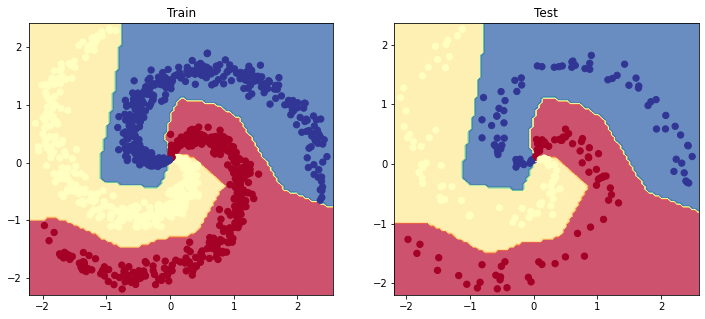

In [55]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary_numpy(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary_numpy(model=model, X=X_test, y=y_test)
plt.show()


In [56]:
#Pytorch

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred


In [57]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [58]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [59]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy


In [62]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [63]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 1.18, accuracy: 25.7
Epoch: 10 | loss: 0.66, accuracy: 56.7
Epoch: 20 | loss: 0.51, accuracy: 73.0
Epoch: 30 | loss: 0.38, accuracy: 87.2
Epoch: 40 | loss: 0.28, accuracy: 91.9
Epoch: 50 | loss: 0.21, accuracy: 93.6
Epoch: 60 | loss: 0.17, accuracy: 95.5
Epoch: 70 | loss: 0.14, accuracy: 96.3
Epoch: 80 | loss: 0.12, accuracy: 97.0
Epoch: 90 | loss: 0.10, accuracy: 97.4


In [64]:
# Predictions
y_prob = model(X_test, apply_softmax=True)
y_pred = y_prob.max(dim=1)[1]


In [65]:
# Performance report
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.9694392174006703,
    "recall": 0.9688888888888889,
    "f1": 0.9687856071193586,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 0.9859154929577465,
      "recall": 0.9333333333333333,
      "f1": 0.9589041095890412,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.9736842105263158,
      "recall": 0.9866666666666667,
      "f1": 0.9801324503311258,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.9487179487179487,
      "recall": 0.9866666666666667,
      "f1": 0.9673202614379085,
      "num_samples": 75.0
    }
  }
}


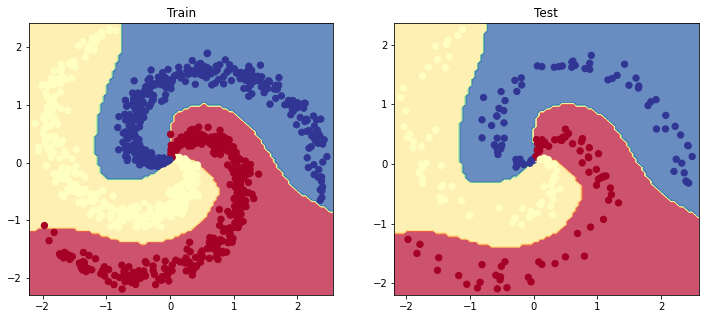

In [66]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


In [67]:
# Inputs for inference
X_infer = pd.DataFrame([{'X1': 0.1, 'X2': 0.1}])


In [68]:
# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)


[[0.27856358 0.33514943]]


In [71]:
# Predict
y_infer = model(torch.Tensor(X_infer), apply_softmax=True)
prob, _class = y_infer.max(dim=1)
label = labelEncoder.inverse_transform(_class.detach().numpy())[0]
print('label :', label)
print (f"The probability that you have {label} is {prob.detach().numpy()[0]*100.0:.0f}%")


label : c1
The probability that you have c1 is 94%


In [73]:
#Using optimized weight initialization tchniques

from torch.nn import init

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

DROPOUT_P = 0.1 # percetange of weights that are dropped each pass


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p) # dropout
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z) # dropout
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [74]:
NUM_EPOCHS = 500
NUM_SAMPLES_PER_CLASS = 50
LEARNING_RATE = 1e-1
HIDDEN_DIM = 2 * NUM_SAMPLES_PER_CLASS * NUM_CLASSES + INPUT_DIM # 2*N*C + D


In [75]:
# Generate random data
X = np.random.rand(NUM_SAMPLES_PER_CLASS * NUM_CLASSES, INPUT_DIM)
y = np.array([[i]*NUM_SAMPLES_PER_CLASS for i in range(NUM_CLASSES)]).reshape(-1)
print ("X: ", format(np.shape(X)))
print ("y: ", format(np.shape(y)))


X:  (150, 2)
y:  (150,)


In [76]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (105, 2), y_train: (105,)
X_val: (22, 2), y_val: (22,)
X_test: (23, 2), y_test: (23,)
Sample point: [0.07998248 0.08982575] → 0


In [77]:
# Standardize the inputs (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)


In [78]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [79]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=302, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=302, out_features=3, bias=True)
)>


In [80]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


In [81]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 1.12, accuracy: 32.4
Epoch: 20 | loss: 1.03, accuracy: 51.4
Epoch: 40 | loss: 0.95, accuracy: 55.2
Epoch: 60 | loss: 0.94, accuracy: 57.1
Epoch: 80 | loss: 0.98, accuracy: 53.3
Epoch: 100 | loss: 0.90, accuracy: 57.1
Epoch: 120 | loss: 0.89, accuracy: 59.0
Epoch: 140 | loss: 0.90, accuracy: 55.2
Epoch: 160 | loss: 0.92, accuracy: 58.1
Epoch: 180 | loss: 0.92, accuracy: 56.2
Epoch: 200 | loss: 0.90, accuracy: 50.5
Epoch: 220 | loss: 0.87, accuracy: 61.9
Epoch: 240 | loss: 0.85, accuracy: 56.2
Epoch: 260 | loss: 0.88, accuracy: 60.0
Epoch: 280 | loss: 0.85, accuracy: 63.8
Epoch: 300 | loss: 0.88, accuracy: 58.1
Epoch: 320 | loss: 0.88, accuracy: 59.0
Epoch: 340 | loss: 0.86, accuracy: 63.8
Epoch: 360 | loss: 0.88, accuracy: 58.1
Epoch: 380 | loss: 0.86, accuracy: 61.9
Epoch: 400 | loss: 0.82, accuracy: 67.6
Epoch: 420 | loss: 0.84, accuracy: 60.0
Epoch: 440 | loss: 0.82, accuracy: 61.9
Epoch: 460 | loss: 0.91, accuracy: 59.0
Epoch: 480 | loss: 0.77, accuracy: 60.0


In [82]:
# Predictions
y_prob = model(X_test, apply_softmax=True)
y_pred = y_prob.max(dim=1)[1]


In [83]:
# Performance report
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.25077639751552794,
    "recall": 0.2608695652173913,
    "f1": 0.25507246376811593,
    "num_samples": 23.0
  },
  "class": {
    "c1": {
      "precision": 0.25,
      "recall": 0.25,
      "f1": 0.25,
      "num_samples": 8.0
    },
    "c2": {
      "precision": 0.375,
      "recall": 0.42857142857142855,
      "f1": 0.39999999999999997,
      "num_samples": 7.0
    },
    "c3": {
      "precision": 0.14285714285714285,
      "recall": 0.125,
      "f1": 0.13333333333333333,
      "num_samples": 8.0
    }
  }
}


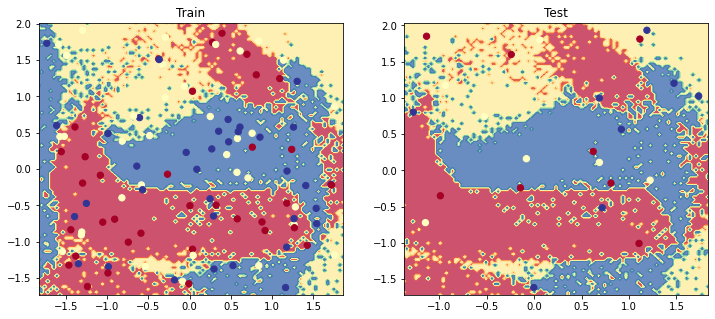

In [84]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()
